# Spam Message Prediction by Using Machine Learning and LLM
## *Predict SPAM messages by using Machine Learning and LLM*
### *Mini Project 3*
> Author: Ng Soo Kuan

### **Business Problems and Understanding**

- Spam messages have significant negative impacts, including financial losses from malware and scams, operational disruptions to businesses, reputational damage to brands, and a substantial drain on IT resources and employee time.
- Government want to co-operate with telco services to reduce the reported cases related to spam messages.
- On the same time, government want to raise the awareness among citizens

### **Proposed Solution by Using Machine Learning & LLM Method**

- Perform text analytic/classification by using machine learning method. Predict the messages whether belongs to Spam or not Spam.
- Send the predicted spam messages to LLM for another step of prediction.
- LLM can explain the reason of messages classify as Spam and highlight the keyword and send to users. It will raises awareness among the users.

<img src="Proposed Analytic Solutions.jpg" width="700" height="600">

### **Data Understanding**
#### *Using the text messages dataset from Kaggle*
#### **Dataset:** *https://www.kaggle.com/code/khotijahs1/using-lstm-for-nlp-text-classification/input*
- **Category:** Messages that belong to spam (spam) or not spam (ham)
- **Message:** Text Messages

In [2]:
#Import the library

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from string import ascii_letters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LearningCurveDisplay
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib

import spacy
import nltk
import en_core_web_sm
import regex as re

from groq import Groq
import requests
from IPython.display import Markdown

In [3]:
# Read Data
message = 'Messages Data.csv'
df = pd.read_csv(message)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Check the data
df.shape

(5572, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


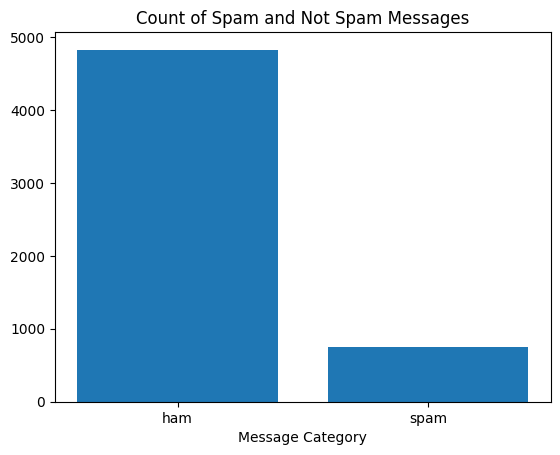

In [6]:
# Check Spam and Not Spam Quantity
label_counts = df['Category'].value_counts()
target = label_counts.index
count = label_counts.values
plt.bar(target, count)
plt.title('Count of Spam and Not Spam Messages')
plt.xlabel('Message Category')
plt.show()

### **Text Analytic & Classification Sequence**
> Raw text --> Train/test split --> Text Cleaning --> Stopword remove --> Stemming & Lemmatization --> Vectorization --> SMOTE --> Model Training --> Evaluation.

### **1. Split Train & Test Dataset**

In [14]:
# Convert Category Variable to Integer
label_mapping = {'ham': 0, 'spam': 1}
df['Category'] = df['Category'].map(label_mapping)
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
## split the dataset
# Features and Labels
X = df['Message']
y = df['Category']

# Apply a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### **2. Visualize the text frequency of SPAM message**

In [19]:
# create a bar chart of the frequency of the words in the text
def plot_words(tokens, top = 30):
    tokens_counter = Counter(tokens)
    tok = [t for (t, _) in tokens_counter.most_common()]
    val = [v for (_, v) in tokens_counter.most_common()]

    plt.figure(figsize = (16, 6))
    plt.bar(tok[:top], val[:top])
    plt.title('Number of terms: %d' % len(tokens_counter))
    plt.xticks(rotation = 90)

    for i, label in enumerate(val[:top]):
        plt.text(i, label, label, ha='center', va='bottom')
    plt.show()

In [21]:
# Select only SPAM message
spam = df[df['Category'] == 1]
spam_message = spam['Message']
spam_message

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: Message, Length: 747, dtype: object

In [23]:
# Combine all rows into 1 
all_text = " ".join(spam_message.astype(str).tolist())

In [25]:
# load spaCy and the English model
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

# process the text
doc = nlp(all_text)

In [26]:
# Tokenise
# spaCy has done it already
for i, t in enumerate(doc):
    print('%2d| %r' % (i+1, t.text))
    if t.text == '.':
        break

 1| 'Free'
 2| 'entry'
 3| 'in'
 4| '2'
 5| 'a'
 6| 'wkly'
 7| 'comp'
 8| 'to'
 9| 'win'
10| 'FA'
11| 'Cup'
12| 'final'
13| 'tkts'
14| '21st'
15| 'May'
16| '2005'
17| '.'


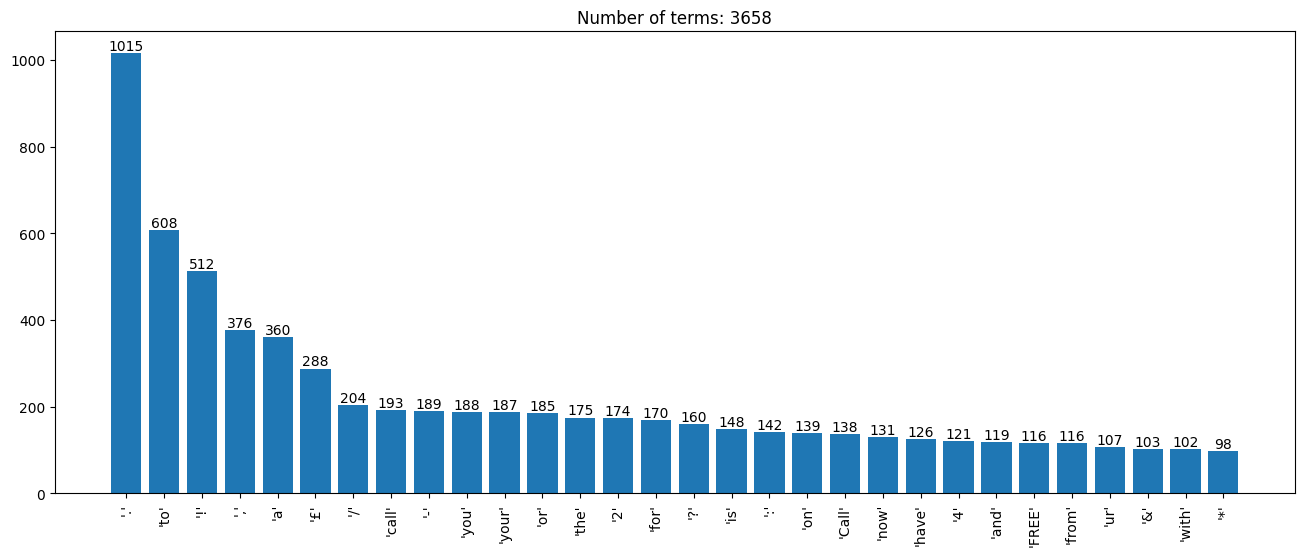

In [27]:
# Visualize the word frequency
plot_words(['%r' % t.text for t in doc])

In [28]:
# Remove Stopwords and Punctuation
## spaCy
print('i | with stop words without')
print('--| --------------- ------------')

# for all the tokens
for i, t in enumerate(doc):
    print('%2d| %-15r %r' % (i+1, t.text, ('' if t.is_stop else t.text)))

    # break after the first sentence
    if t.text == '.':
        break

i | with stop words without
--| --------------- ------------
 1| 'Free'          'Free'
 2| 'entry'         'entry'
 3| 'in'            ''
 4| '2'             '2'
 5| 'a'             ''
 6| 'wkly'          'wkly'
 7| 'comp'          'comp'
 8| 'to'            ''
 9| 'win'           'win'
10| 'FA'            'FA'
11| 'Cup'           'Cup'
12| 'final'         'final'
13| 'tkts'          'tkts'
14| '21st'          '21st'
15| 'May'           ''
16| '2005'          '2005'
17| '.'             '.'


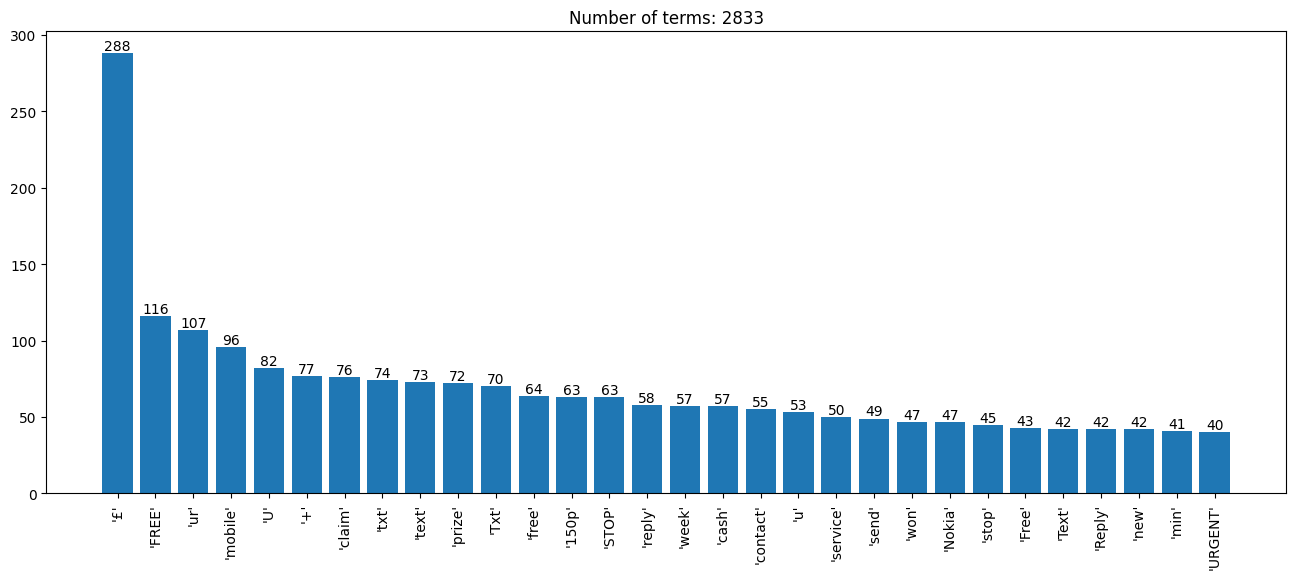

In [29]:
plot_words(['%r' % t.text for t in doc if not (t.is_stop | t.is_punct | t.is_digit)]) # Remove stop words, digit, punctuation

### **2.1 Text Cleaning**

In [31]:
nlp = spacy.load('en_core_web_sm')

In [32]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [40]:
# Apply the clean_text function to your dataset.
X_train = X_train.apply(clean_text)
print(X_train.head())

184                              He will, you guys close?
2171    CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER ...
5422              Ok k..sry i knw 2 siva..tats y i askd..
4113                            I'll see, but prolly yeah
4588    I'll see if I can swing by in a bit, got some ...
Name: Message, dtype: object


In [42]:
# Remove stopword, punctuation and return lemmatised form of remaining words in lower case
def convert_text(text):
    '''
    Use techniques learned in previous labs.
    1) Remove StopWords, Punctuation and digits.
    2) Retain entities.
    3) Return the lemmatised form of remaining words in lower case form.
    '''
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else: 
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)
    return text

In [44]:
%%time
X_train = X_train.apply(convert_text)
print(X_train.head())

184                                             guy close
2171    come imin town.dontmatter urgoin outl8r really...
5422                         ok k sry knw siva tat y askd
4113                                          prolly yeah
4588                       swing bit get thing care firsg
Name: Message, dtype: object
CPU times: total: 34.1 s
Wall time: 34.6 s


### **3. Vectorization**

> **Create Bag-of-Words Model**

In [48]:
# create a matrix of word counts from the text
counts = CountVectorizer(ngram_range=(1,2), min_df=1)
# do the actual counting
A = counts.fit_transform(X_train)

> **Create TF-IDF model**

In [51]:
# create a matrix of word counts from the text
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1)
# do the actual counting
B = tfidf.fit_transform(X_train)

### **4. Train the Model**

> **Boosting with Bag of Words**

In [55]:
# Fit the model by using boosting on Bag of Words
base_estimator = DecisionTreeClassifier(max_depth = 1, class_weight = 'balanced')
model_a = AdaBoostClassifier(estimator = base_estimator, n_estimators = 50, random_state = 42, algorithm='SAMME')
model_a.fit(A, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1),
                   random_state=42)

In [57]:
# Do the transformation for the test data
A1 = counts.transform(X_test)

# Make prediction based on test data
predictions = model_a.predict(A1)

# Store Probabilities of predictions being 1
probabilities = model_a.predict_proba(A1)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.8906


> **Boosting with TF-IDF**

In [60]:
# Fit the model by using boosting on TF-IDF
base_estimator = DecisionTreeClassifier(max_depth = 1, class_weight = 'balanced')
model_b = AdaBoostClassifier(estimator = base_estimator, n_estimators = 50, random_state = 42, algorithm='SAMME')
model_b.fit(B, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=1),
                   random_state=42)

In [62]:
# Do the transformation for the test data
B1 = tfidf.transform(X_test)

# Make prediction based on test data
predictions = model_b.predict(B1)

# Store Probabilities of predictions being 1
probabilities = model_b.predict_proba(B1)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.8906


> **Stacking with Bag of Words**

In [65]:
# Fit the model by using Stacking on Bag of Words
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, class_weight = 'balanced')),
    ('svm', SVC(probability=True, class_weight = 'balanced'))
]

meta_learner = LogisticRegression (max_iter = 1000, random_state =42, class_weight = 'balanced')

stack = StackingClassifier(
    estimators = estimators , final_estimator = meta_learner)

stack.fit(A, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=3)),
                               ('svm',
                                SVC(class_weight='balanced',
                                    probability=True))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000,
                                                      random_state=42))

In [66]:
# Do the transformation for the test data
A1 = counts.transform(X_test)

# Make prediction based on test data
predictions = stack.predict(A1)

# Store Probabilities of predictions being 1
probabilities = stack.predict_proba(A1)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.9578


> **Stacking with TF_IDF**

In [68]:
# Fit the model by using Stacking on Bag of Words
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, class_weight = 'balanced')),
    ('svm', SVC(probability=True, class_weight = 'balanced'))
]

meta_learner = LogisticRegression (max_iter = 1000, random_state =42, class_weight = 'balanced')

stack = StackingClassifier(
    estimators = estimators , final_estimator = meta_learner)

stack.fit(B, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=3)),
                               ('svm',
                                SVC(class_weight='balanced',
                                    probability=True))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000,
                                                      random_state=42))

In [69]:
# Do the transformation for the test data
B1 = tfidf.transform(X_test)

# Make prediction based on test data
predictions = stack.predict(B1)

# Store Probabilities of predictions being 1
probabilities = stack.predict_proba(B1)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.9821


### **Construct Model Pipeline**

In [74]:
# Construct model pipeline (TF-IDF)
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=1)),       # Set ngram and min_df for reproducibility
    ('stack', stack)  # classifier
])

# Run Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_tfidf, X_train, y_train, cv=cv, scoring ='accuracy')

print(f"Accuracy: {scores.mean():.2f} +/- {scores.std():.3f}")        

Accuracy: 0.97 +/- 0.004


In [75]:
# Construct model pipeline (Bag of Words)
pipe_bow = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,2), min_df=1)),          # Set ngram and min_df for reproducibility
    ('stack', stack)  # classifier
])

# Run Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_bow, X_train, y_train, cv=cv, scoring ='accuracy')

print(f"Accuracy: {scores.mean():.2f} +/- {scores.std():.3f}")       

Accuracy: 0.98 +/- 0.004


In [76]:
# Predict on X_test
# Make prediction based on test data
pipe_bow.fit(X_train, y_train)
predictions = pipe_bow.predict(X_test)

# Store Probabilities of predictions being 1
probabilities = pipe_bow.predict_proba(X_test)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.9596


In [77]:
# Predict on X_test
# Make prediction based on test data
pipe_tfidf.fit(X_train, y_train)
predictions = pipe_tfidf.predict(X_test)

# Store Probabilities of predictions being 1
probabilities = pipe_tfidf.predict_proba(X_test)[:, 1]

# Check the Accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.9821


> **Show the results and charts**

In [82]:
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

    return (accuracy_, precision_, recall_, roc_auc_)

**********
* counts *
**********
Accuracy : 0.9596 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8467 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8523 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9665                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


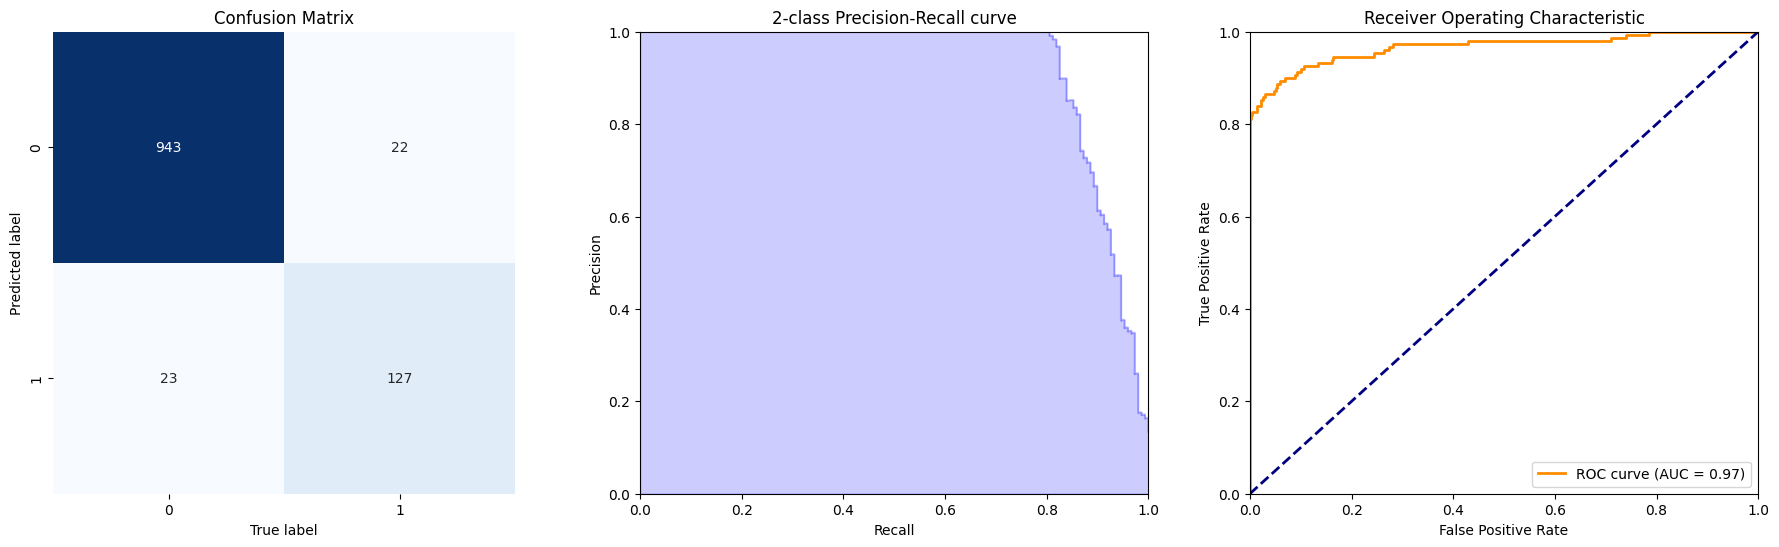

**********
* TF-IDF *
**********
Accuracy : 0.9821 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9448 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9195 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9882                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


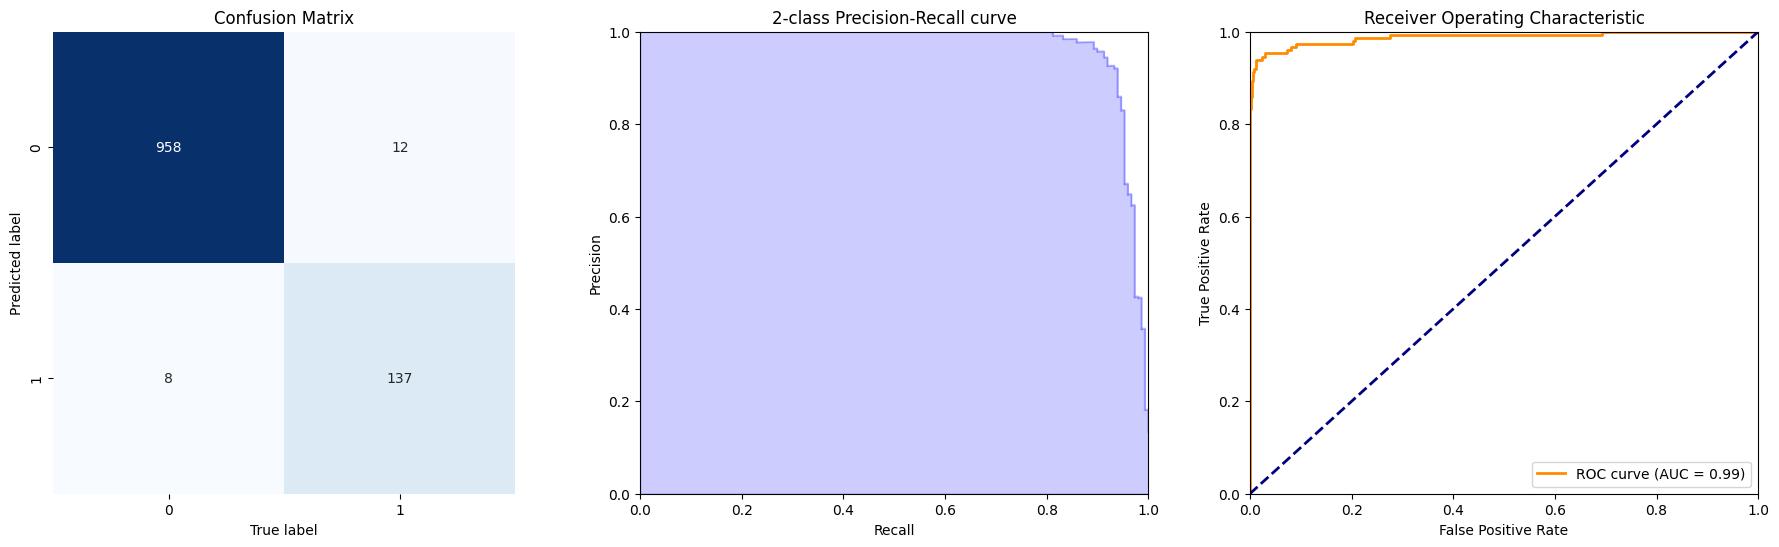

In [84]:
results = pd.DataFrame(columns =['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['counts', 'TF-IDF']
for i , m in enumerate([pipe_bow, pipe_tfidf]):
    print('*' * (len(models[i]) +4 ))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) +4))

    counts = m

    counts.fit(X_train, y_train)

    predictions = counts.predict(X_test)

    probabilities = counts.predict_proba(X_test)[:, 1]

    accuracy_ , precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)

    results.loc[i] = {
        'models' : models[i],
        'accuracy' : accuracy_,
        'precision' : precision_,
        'recall' : recall_,
        'ROC_AUC' : roc_auc_ }

### **However Recall will be choosing as the metric because we need to identify True spam message as much as possible.**
> **Therefore Stacking with TF-IDF (Recall = 0.9195) is choosing as the model to predict SPAM message.**

In [86]:
# Save the pipeline (Include Vectorizer + Model)
joblib.dump(pipe_tfidf, "spam_classifier.joblib")

['spam_classifier.joblib']

## **Send the Predicted SPAM messages to LLM for prediction and explain to users** 

In [89]:
groqfilename = r'groq_key.txt' # this file contains a single line containing your Groq API key only
try:
    with open(groqfilename, 'r') as f:
        groq_key = f.read().strip()
except FileNotFoundError:
    print(f"'{groqfilename}' file not found")

In [91]:
client = Groq(api_key=groq_key)

In [92]:
# Fast classification
# Sample 50 messages for predictons
sampled_messages = X_test.sample(n=50, random_state=42) #Sampling 50 messages for testing instead of using all X_test dataset

probs = pipe_tfidf.predict_proba(sampled_messages)[:, 1]  # probability of spam

results = []

sampled_messages = X_test.sample(n=50, random_state=42) #Sampling 100 messages for testing instead of using all X_test dataset

# Loop through test messages
for i, prob in enumerate(probs):
    message = sampled_messages.iloc[i]  # get actual text message
    
    if prob > 0.5:  # spam threshold
        # Step 3: Send to LLM for explanation
        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a spam detection assistant. "
                        "Classify the message as SPAM or NOT SPAM, "
                        "explain the reason, and highlight the suspicious keywords."
                    )
                },
                {
                    "role": "user",
                    "content": f"Message:\n{message}\n\nClassify and explain."
                }
            ],
        )
        
        explanation = response.choices[0].message.content
        
        print(f"Message {i} classified as SPAM (prob={prob:.2f})")
        print(explanation)
        print("-----")

        results.append({
            "message": message,
            "probability": prob,
            "explanation": explanation
        })
    else:
        results.append({
            "message": message,
            "probability": prob,
            "explanation": "Not spam - skipped LLM"
        })

# Convert results into DataFrame for review/export
df_results = pd.DataFrame(results)
print(df_results)

Message 0 classified as SPAM (prob=0.93)
I would classify this message as **SPAM**.

The reason for this classification is that the message appears to be an unsolicited advertisement, prompting the recipient to click on a link to obtain free premium content. This is a common tactic used by spammers to lure users into visiting malicious websites, downloading malware, or signing up for unwanted services.

The suspicious keywords in this message are:

* **"Hit the link"**: This phrase is often used by spammers to encourage users to click on a URL without verifying its legitimacy.
* **"all 4 FREE!"**: This phrase is a common marketing gimmick used to create a sense of urgency and entice users into taking action without considering the potential consequences.

Overall, the message has a spammy tone and is likely intended to trick users into clicking on a link that may compromise their security or flood their device with unwanted content.
-----
Message 6 classified as SPAM (prob=1.00)
I woul